# Analysis per epitopes

In this nb (25d2), in comparison to 25d, we focus on the Epipos test set, in which we have the positive dataset with only epitope-specific sequences and the negative dataset with non-epitope-specific seqeunces.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

from NegativeClassOptimization import utils, preprocessing, ml, config, datasets, visualisations

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ID Performance

In [6]:
from scipy.stats import pearsonr


def plot_acc_jsd(df):
    cmap = visualisations.PlotParams.cmap_tasks

    order_tasks = ["high_vs_95low", "1v1", "1v9", "high_vs_looser", "1v1_epitope"]
    order_tasks_clean = list(map(lambda x: visualisations.map_task_type_to_clean[x], order_tasks))

    sns.set_theme(context="paper")
    sns.set_style("white")
    fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)

    # Line plot in seaborn with R2 regression
    for i, df_g in df.groupby("task_type_clean"):
        print(i)
        color = cmap[order_tasks_clean.index(i)] # type: ignore
        sns.regplot(
            x="jsd",
            y="acc",
            data=df_g,
            scatter=True,
            color=color,
            ax=ax,
            label=i,
        )

        # Compute Pearson correlation
        r, pval = pearsonr(df_g["jsd"], df_g["acc"])
        print(f"{i}: r={r:.2f}, p={pval:.2f}")
        # Add text with r and R2 at centroid
        x = df_g["jsd"].mean()
        y = df_g["acc"].mean()
        ax.text(x, y, f"r={r:.2f}, R2={r**2:.2f}", fontsize=10, fontweight="bold")

    FONT_SIZE = 12
    ax.tick_params(labelsize=FONT_SIZE)
    ax.legend(
        bbox_to_anchor=(0.5, -0.3),
        loc="center",
        borderaxespad=0.0,
        fontsize=7,
        title="Task",
        title_fontsize=8,
        ncol=10,
        frameon=False,
    )
    ax.set_xlabel("Jensen-Shannon Divergence", fontsize=FONT_SIZE)
    ax.set_ylabel("Accuracy", fontsize=FONT_SIZE)

In [7]:
def process_df_id(df_id):
    """Extract some relevant columns from task_type object."""
    df_id["task_obj"] = df_id["task"].apply(lambda x: datasets.ClassificationTask.init_from_str(x))
    df_id["task_type"] = df_id["task_obj"].apply(lambda x: x.task_type.to_str())
    df_id["pos_dataset"] = df_id["task_obj"].apply(lambda x: x.get_nco_ag_pos())
    df_id["neg_dataset"] = df_id["task_obj"].apply(lambda x: x.get_nco_ag_neg())

    df_id["ag_pos"] = df_id["pos_dataset"].apply(lambda x: x.split("_")[0])
    df_id["ag_neg"] = df_id["neg_dataset"].apply(lambda x: x.split("_")[0])

    df_id["task_type_clean"] = df_id["task_type"].apply(lambda x: visualisations.PlotParams.map_task_type_to_clean[x])
    return df_id

In [4]:
df_id_antigen = pd.read_csv("../data/closed_performance.tsv", sep='\t')
df_id_antigen = process_df_id(df_id_antigen)

antigens_selector = [ag.split("E1")[0] for ag in config.ANTIGEN_EPITOPES]
df_id_antigen = df_id_antigen.query("ag_pos in @antigens_selector").copy()

df_id_antigen.head()

,task,acc,recall,precision,f1,task_obj,task_type,pos_dataset,neg_dataset,ag_pos,ag_neg,task_type_clean
432,ONE_VS_ONE__1H0D__3VRL__0__42,0.9914,0.9878,0.994964,0.991369,ONE_VS_ONE__1H0D__3VRL__0__42,1v1,1H0D,3VRL,1H0D,3VRL,vs 1
433,ONE_VS_ONE__1H0D__3VRL__1__42,0.9935,0.9924,0.994588,0.993493,ONE_VS_ONE__1H0D__3VRL__1__42,1v1,1H0D,3VRL,1H0D,3VRL,vs 1
434,ONE_VS_ONE__1H0D__3VRL__2__42,0.9929,0.9900,0.995775,0.992879,ONE_VS_ONE__1H0D__3VRL__2__42,1v1,1H0D,3VRL,1H0D,3VRL,vs 1
435,ONE_VS_ONE__1H0D__3VRL__3__42,0.9932,0.9920,0.994387,0.993192,ONE_VS_ONE__1H0D__3VRL__3__42,1v1,1H0D,3VRL,1H0D,3VRL,vs 1
436,ONE_VS_ONE__1H0D__3VRL__0__0,0.9928,0.9910,0.994580,0.992787,ONE_VS_ONE__1H0D__3VRL__0__0,1v1,1H0D,3VRL,1H0D,3VRL,vs 1


In [5]:
## 1) +: only epitope specific, -: epitope non-specific (as previously)

## To make the analysis easier, we generated adapted test sets in MiniAbsolut
## for this scenario: 01c2_Epitopes_to_MiniAbsolut.ipynb.

## We then evaluate the performance on the new test sets in 
## script 14/14b, which mimics transfer of frozen performance, with
## the only caveat of the test set being different. It loads the same task (model),
## but evaluates it on different test sets and adds a column to the same file (acc_epi_pos).


### REFACTOR using functions


df_id = pd.read_csv(
    "../data/closed_performance_epitopes_pos.tsv",
    sep='\t'
)

df_id = process_df_id(df_id)

selector = (df_id["task_type"] == "1v1") & (df_id["ag_neg"].isin(config.ANTIGEN_EPITOPES))
df_id.loc[selector, "task_type"] = "1v1_epitope"
df_id.loc[selector, "task_type_clean"] = "vs 1 (Epitopes)"

df_id["acc"] = df_id["acc_epi_pos"]

df_id.head()

,task,N_test_pos,N_test_neg,acc_epi_pos,recall_epi_pos,precision_epi_pos,f1_epi_pos,task_obj,task_type,pos_dataset,neg_dataset,ag_pos,ag_neg,task_type_clean,acc
0,ONE_VS_ONE__1H0DE1__3VRL__0__42,3000,3000,0.993167,0.992000,0.994320,0.993159,ONE_VS_ONE__1H0DE1__3VRL__0__42,1v1,1H0DE1,3VRL,1H0DE1,3VRL,vs 1,0.993167
1,ONE_VS_ONE__1H0DE1__1NSN__0__42,3000,3000,0.994167,0.994667,0.993673,0.994170,ONE_VS_ONE__1H0DE1__1NSN__0__42,1v1,1H0DE1,1NSN,1H0DE1,1NSN,vs 1,0.994167
2,ONE_VS_ONE__1H0DE1__3RAJ__0__42,3000,3000,0.978333,0.968333,0.988095,0.978114,ONE_VS_ONE__1H0DE1__3RAJ__0__42,1v1,1H0DE1,3RAJ,1H0DE1,3RAJ,vs 1,0.978333
3,ONE_VS_ONE__1H0DE1__5E94__0__42,3000,3000,0.976667,0.966667,0.986395,0.976431,ONE_VS_ONE__1H0DE1__5E94__0__42,1v1,1H0DE1,5E94,1H0DE1,5E94,vs 1,0.976667
4,ONE_VS_ONE__1H0DE1__1WEJ__0__42,3000,3000,0.987833,0.988000,0.987671,0.987835,ONE_VS_ONE__1H0DE1__1WEJ__0__42,1v1,1H0DE1,1WEJ,1H0DE1,1WEJ,vs 1,0.987833


In [8]:
df_id_ext = pd.concat([df_id, df_id_antigen], axis=0)
df_id_ext.head()

,task,N_test_pos,N_test_neg,acc_epi_pos,recall_epi_pos,precision_epi_pos,f1_epi_pos,task_obj,task_type,pos_dataset,neg_dataset,ag_pos,ag_neg,task_type_clean,acc,recall,precision,f1
0,ONE_VS_ONE__1H0DE1__3VRL__0__42,3000.0,3000.0,0.993167,0.992000,0.994320,0.993159,ONE_VS_ONE__1H0DE1__3VRL__0__42,1v1,1H0DE1,3VRL,1H0DE1,3VRL,vs 1,0.993167,NaN,NaN,NaN
1,ONE_VS_ONE__1H0DE1__1NSN__0__42,3000.0,3000.0,0.994167,0.994667,0.993673,0.994170,ONE_VS_ONE__1H0DE1__1NSN__0__42,1v1,1H0DE1,1NSN,1H0DE1,1NSN,vs 1,0.994167,NaN,NaN,NaN
2,ONE_VS_ONE__1H0DE1__3RAJ__0__42,3000.0,3000.0,0.978333,0.968333,0.988095,0.978114,ONE_VS_ONE__1H0DE1__3RAJ__0__42,1v1,1H0DE1,3RAJ,1H0DE1,3RAJ,vs 1,0.978333,NaN,NaN,NaN
3,ONE_VS_ONE__1H0DE1__5E94__0__42,3000.0,3000.0,0.976667,0.966667,0.986395,0.976431,ONE_VS_ONE__1H0DE1__5E94__0__42,1v1,1H0DE1,5E94,1H0DE1,5E94,vs 1,0.976667,NaN,NaN,NaN
4,ONE_VS_ONE__1H0DE1__1WEJ__0__42,3000.0,3000.0,0.987833,0.988000,0.987671,0.987835,ONE_VS_ONE__1H0DE1__1WEJ__0__42,1v1,1H0DE1,1WEJ,1H0DE1,1WEJ,vs 1,0.987833,NaN,NaN,NaN


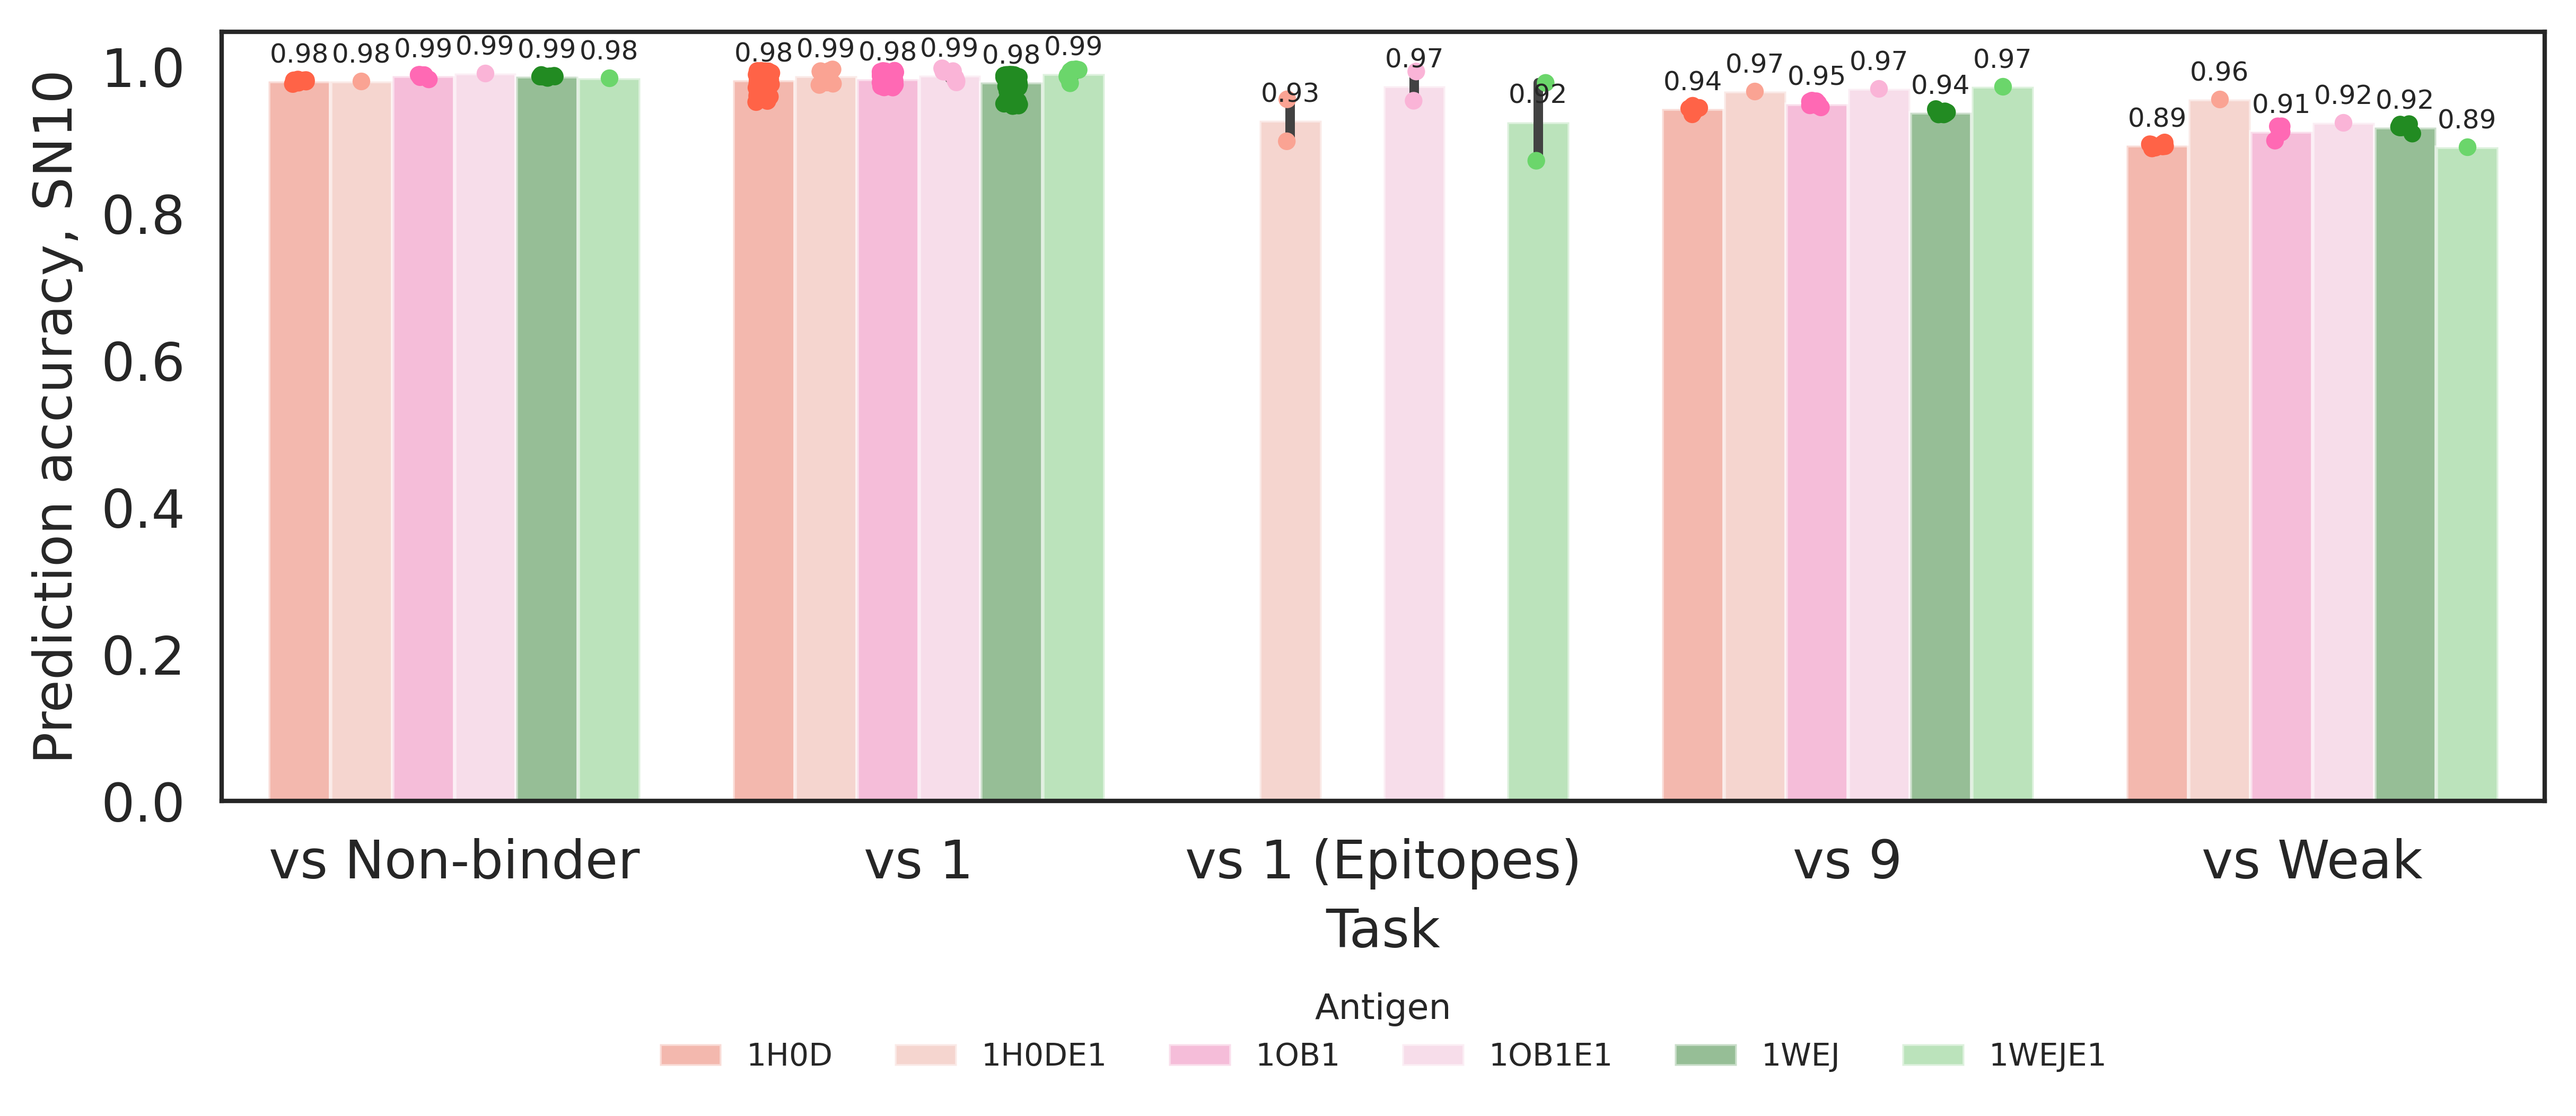

In [9]:
ag_order = ["1H0D", "1H0DE1", "1OB1", "1OB1E1", "1WEJ", "1WEJE1"]
task_order = ["high_vs_95low", "1v1", "1v1_epitope", "1v9", "high_vs_looser"]
task_clean_order = [visualisations.PlotParams.map_task_type_to_clean[x] for x in task_order]

palette = {
 '1WEJ': '#228B22',
 '1WEJE1': "#6bd66b",
 '1OB1': '#FF69B4',
 '1OB1E1': '#fab4d7',
 '1H0D': '#FF6347',
 '1H0DE1': '#faa393',
}

sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(3 * 3.14, 3.14), dpi=600)

# Transparent boxplot
sns.barplot(
    x="task_type_clean",
    y="acc",
    hue="ag_pos",
    data=df_id_ext,
    ax=ax,
    order=task_clean_order,
    hue_order=ag_order,
    palette=palette,
    alpha=0.5,
)
# Add data points on top of boxplot in low transparency
sns.stripplot(
    x="task_type_clean",
    y="acc",
    hue="ag_pos",
    data=df_id_ext,
    ax=ax,
    order=task_clean_order,
    hue_order=ag_order,
    palette=palette,
    alpha=1.0,
    dodge=True,
    size=4,
    legend=False, # type: ignore
)

# visualisations.add_median_labels(ax, y_level=0.85, fontsize=8)
for i in range(6):
    ax.bar_label(ax.containers[i], fontsize=6, fmt="%1.2f", label_type="edge", padding=3)

ax.tick_params(labelsize=12)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Antigen",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)
ax.set_xlabel("Task", fontsize=12)
ax.set_ylabel("Prediction accuracy, SN10", fontsize=12)
# ax.set_title("", fontsize=12)

# fig.savefig("")
fig.show()

In [10]:
df_id_antigen.head()

,task,acc,recall,precision,f1,task_obj,task_type,pos_dataset,neg_dataset,ag_pos,ag_neg,task_type_clean
432,ONE_VS_ONE__1H0D__3VRL__0__42,0.9914,0.9878,0.994964,0.991369,ONE_VS_ONE__1H0D__3VRL__0__42,1v1,1H0D,3VRL,1H0D,3VRL,vs 1
433,ONE_VS_ONE__1H0D__3VRL__1__42,0.9935,0.9924,0.994588,0.993493,ONE_VS_ONE__1H0D__3VRL__1__42,1v1,1H0D,3VRL,1H0D,3VRL,vs 1
434,ONE_VS_ONE__1H0D__3VRL__2__42,0.9929,0.9900,0.995775,0.992879,ONE_VS_ONE__1H0D__3VRL__2__42,1v1,1H0D,3VRL,1H0D,3VRL,vs 1
435,ONE_VS_ONE__1H0D__3VRL__3__42,0.9932,0.9920,0.994387,0.993192,ONE_VS_ONE__1H0D__3VRL__3__42,1v1,1H0D,3VRL,1H0D,3VRL,vs 1
436,ONE_VS_ONE__1H0D__3VRL__0__0,0.9928,0.9910,0.994580,0.992787,ONE_VS_ONE__1H0D__3VRL__0__0,1v1,1H0D,3VRL,1H0D,3VRL,vs 1


In [11]:
# Load jsds for the non-epitope based analysis
import json
from NegativeClassOptimization.utils import jensen_shannon_divergence_slides 

jsds_fp = Path("25d2_jsds.json")

if not jsds_fp.exists():
    loader = datasets.FrozenMiniAbsolutMLLoader(Path("../data/Frozen_MiniAbsolut_ML"))
    jsds = []
    for task_str in df_id_antigen["task"]:
        task = datasets.ClassificationTask.init_from_str(task_str)
        loader.load(task)
        slides_neg = task.test_dataset.query("binds_a_pos_ag == 0")["Slide"].to_list() # type: ignore
        slides_pos = task.test_dataset.query("binds_a_pos_ag == 1")["Slide"].to_list() # type: ignore
        jsd = jensen_shannon_divergence_slides(slides_neg, slides_pos)
        jsds.append(jsd)
    with open(jsds_fp, "w") as f:
        json.dump(jsds, f)
else:
    with open(jsds_fp, "r") as f:
        jsds = json.load(f)

df_id_antigen["jsd"] = jsds

In [12]:
# Load jsds for epitopes
df_jsd = pd.read_csv(
    "../data/jsd_epitopes_pos.tsv",
    sep='\t'
)
df_jsd.dropna(inplace=True)

df_id = pd.merge(
    df_id,
    df_jsd,
    on=["task"],
    how="inner"
)

df_id["acc"] = df_id["acc_epi_pos"]

In [13]:
df_id_ext = pd.concat([df_id, df_id_antigen], axis=0)

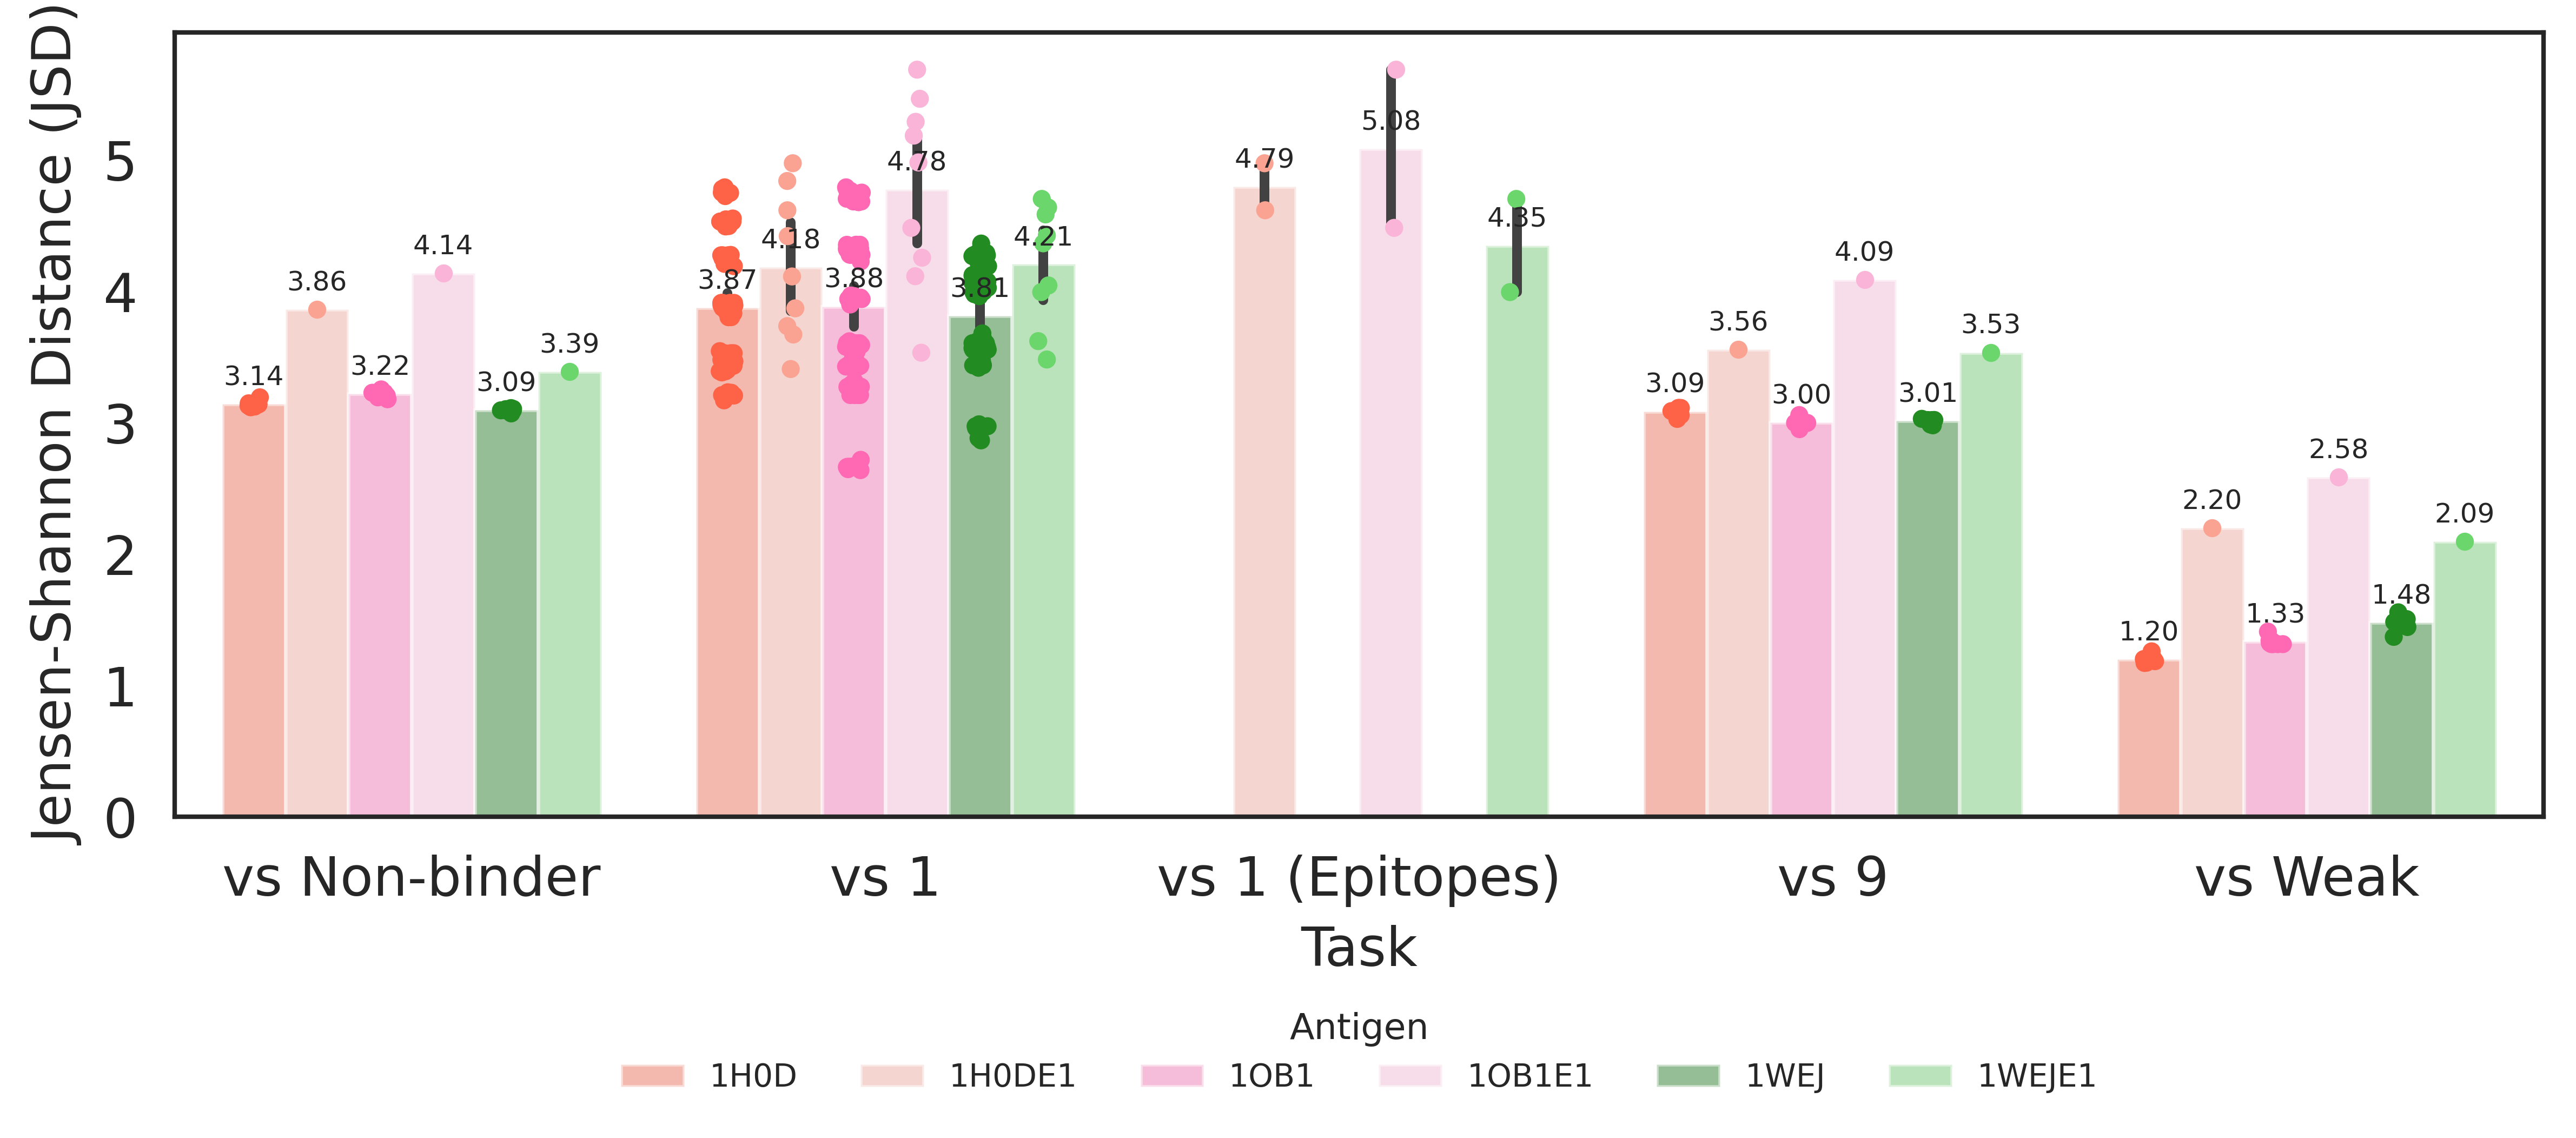

In [14]:
ag_order = ["1H0D", "1H0DE1", "1OB1", "1OB1E1", "1WEJ", "1WEJE1"]
task_order = ["high_vs_95low", "1v1", "1v1_epitope", "1v9", "high_vs_looser"]
task_clean_order = [visualisations.PlotParams.map_task_type_to_clean[x] for x in task_order]

palette = {
 '1WEJ': '#228B22',
 '1WEJE1': "#6bd66b",
 '1OB1': '#FF69B4',
 '1OB1E1': '#fab4d7',
 '1H0D': '#FF6347',
 '1H0DE1': '#faa393',
}

sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(3 * 3.14, 3.14), dpi=600)

# Transparent boxplot
sns.barplot(
    x="task_type_clean",
    y="jsd",
    hue="ag_pos",
    data=df_id_ext,
    ax=ax,
    order=task_clean_order,
    hue_order=ag_order,
    palette=palette,
    alpha=0.5,
)
# Add data points on top of boxplot in low transparency
sns.stripplot(
    x="task_type_clean",
    y="jsd",
    hue="ag_pos",
    data=df_id_ext,
    ax=ax,
    order=task_clean_order,
    hue_order=ag_order,
    palette=palette,
    alpha=1.0,
    dodge=True,
    size=4,
    legend=False, # type: ignore
)

# visualisations.add_median_labels(ax, y_level=0.85, fontsize=8)
for i in range(6):
    ax.bar_label(ax.containers[i], fontsize=6, fmt="%1.2f", label_type="edge", padding=3)

ax.tick_params(labelsize=12)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Antigen",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)
ax.set_xlabel("Task", fontsize=12)
ax.set_ylabel("Jensen-Shannon Distance (JSD)", fontsize=12)
# ax.set_title("", fontsize=12)

# fig.savefig("")
fig.show()

OOD Performance

In [15]:
task_order = visualisations.PlotParams.order_tasks_clean.copy()
def plot_ood(df_ood, task_order=task_order):

    cmap = [
        # Selection from Dutch Field
        "#00bfa0",  # Dark Green
        "#0bb4ff",  # Blue
        "#e60049",  # Red
        "#ff8800",  # Orange
    ]

    fig, ax = plt.subplots(figsize=(2.5 * 3.14, 1.2 * 3.14), dpi=600)
    sns.pointplot(
        df_ood,
        y="acc",
        x="test_task_type_clean",
        errorbar="sd",
        order=task_order,
        hue="model_task_type_clean",
        hue_order=task_order,
        palette=cmap,
        # Spread out the points a bit in horizontal
        dodge=0.3,
        ax=ax,
    )

    # Add legend horizontally on top of plot area, outside plot area
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.15),
        ncol=4,
        fontsize=8,
        frameon=False,
        # title="Model trained on",
        # title_fontsize=8,
    )

    ax.set_xlabel(None)
    ax.set_ylabel("Prediction accuracy")

    # Add text
    for i, col in enumerate(ax.collections):
        for j, txt in enumerate(col.get_offsets()[:, 0]):
            ax.text(
                txt,
                col.get_offsets()[j, 1],
                f"{col.get_offsets()[j, 1]:.2f}",
                ha="center",
                va="bottom",
                color="black",
                fontsize=8,
                fontweight="bold",
            )

    # ax.set_title("OOD Performance for logistic regression")
    fig.show()

In [16]:
df_ood = pd.read_csv(
    "../data/openset_performance_epitopes_pos.tsv",
    sep='\t'
)

df_ood["task_obj_1"] = df_ood["task_1"].apply(lambda x: datasets.ClassificationTask.init_from_str(x))
df_ood["task_obj_2"] = df_ood["task_2"].apply(lambda x: datasets.ClassificationTask.init_from_str(x))


df_ood["model_task_type"] = df_ood["task_obj_1"].apply(lambda x: x.task_type.to_str())
df_ood["test_task_type"] = df_ood["task_obj_2"].apply(lambda x: x.task_type.to_str())

df_ood["model_pos_dataset"] = df_ood["task_obj_1"].apply(lambda x: x.get_nco_ag_pos())
df_ood["model_neg_dataset"] = df_ood["task_obj_1"].apply(lambda x: x.get_nco_ag_neg())
df_ood["test_pos_dataset"] = df_ood["task_obj_2"].apply(lambda x: x.get_nco_ag_pos())
df_ood["test_neg_dataset"] = df_ood["task_obj_2"].apply(lambda x: x.get_nco_ag_neg())


df_ood["model_ag_pos"] = df_ood["model_pos_dataset"].apply(lambda x: x.split("_")[0])
df_ood["model_ag_neg"] = df_ood["model_neg_dataset"].apply(lambda x: x.split("_")[0])

df_ood["test_ag_pos"] = df_ood["test_pos_dataset"].apply(lambda x: x.split("_")[0])
df_ood["test_ag_neg"] = df_ood["test_neg_dataset"].apply(lambda x: x.split("_")[0])


df_ood["model_task_type_clean"] = df_ood["model_task_type"].apply(lambda x: visualisations.PlotParams.map_task_type_to_clean[x])
df_ood["test_task_type_clean"] = df_ood["test_task_type"].apply(lambda x: visualisations.PlotParams.map_task_type_to_clean[x])


selector = (
    ((df_ood["model_task_type"] == "1v1") & (df_ood["model_ag_neg"].isin(config.ANTIGEN_EPITOPES)))
    |
    ((df_ood["test_task_type"] == "1v1") & (df_ood["test_ag_neg"].isin(config.ANTIGEN_EPITOPES)))
)
df_ood = df_ood.loc[~selector].copy()

print(df_ood.shape)
df_ood.head(5)

(432, 22)


,task_1,task_2,task_2_N_test_pos,task_2_N_test_neg,acc,recall,precision,f1,task_obj_1,task_obj_2,...,model_pos_dataset,model_neg_dataset,test_pos_dataset,test_neg_dataset,model_ag_pos,model_ag_neg,test_ag_pos,test_ag_neg,model_task_type_clean,test_task_type_clean
0,ONE_VS_ONE__1H0DE1__3VRL__0__42,ONE_VS_ONE__1H0DE1__3VRL__0__42,3000,3000,0.993167,0.992,0.994320,0.993159,ONE_VS_ONE__1H0DE1__3VRL__0__42,ONE_VS_ONE__1H0DE1__3VRL__0__42,...,1H0DE1,3VRL,1H0DE1,3VRL,1H0DE1,3VRL,1H0DE1,3VRL,vs 1,vs 1
1,ONE_VS_ONE__1H0DE1__3VRL__0__42,ONE_VS_ONE__1H0DE1__1NSN__0__42,3000,3000,0.726333,0.992,0.647801,0.783777,ONE_VS_ONE__1H0DE1__3VRL__0__42,ONE_VS_ONE__1H0DE1__1NSN__0__42,...,1H0DE1,3VRL,1H0DE1,1NSN,1H0DE1,3VRL,1H0DE1,1NSN,vs 1,vs 1
2,ONE_VS_ONE__1H0DE1__3VRL__0__42,ONE_VS_ONE__1H0DE1__3RAJ__0__42,3000,3000,0.871667,0.992,0.799570,0.885451,ONE_VS_ONE__1H0DE1__3VRL__0__42,ONE_VS_ONE__1H0DE1__3RAJ__0__42,...,1H0DE1,3VRL,1H0DE1,3RAJ,1H0DE1,3VRL,1H0DE1,3RAJ,vs 1,vs 1
3,ONE_VS_ONE__1H0DE1__3VRL__0__42,ONE_VS_ONE__1H0DE1__5E94__0__42,3000,3000,0.697667,0.992,0.624423,0.766418,ONE_VS_ONE__1H0DE1__3VRL__0__42,ONE_VS_ONE__1H0DE1__5E94__0__42,...,1H0DE1,3VRL,1H0DE1,5E94,1H0DE1,3VRL,1H0DE1,5E94,vs 1,vs 1
4,ONE_VS_ONE__1H0DE1__3VRL__0__42,ONE_VS_ONE__1H0DE1__1WEJ__0__42,3000,3000,0.932167,0.992,0.885978,0.935996,ONE_VS_ONE__1H0DE1__3VRL__0__42,ONE_VS_ONE__1H0DE1__1WEJ__0__42,...,1H0DE1,3VRL,1H0DE1,1WEJ,1H0DE1,3VRL,1H0DE1,1WEJ,vs 1,vs 1


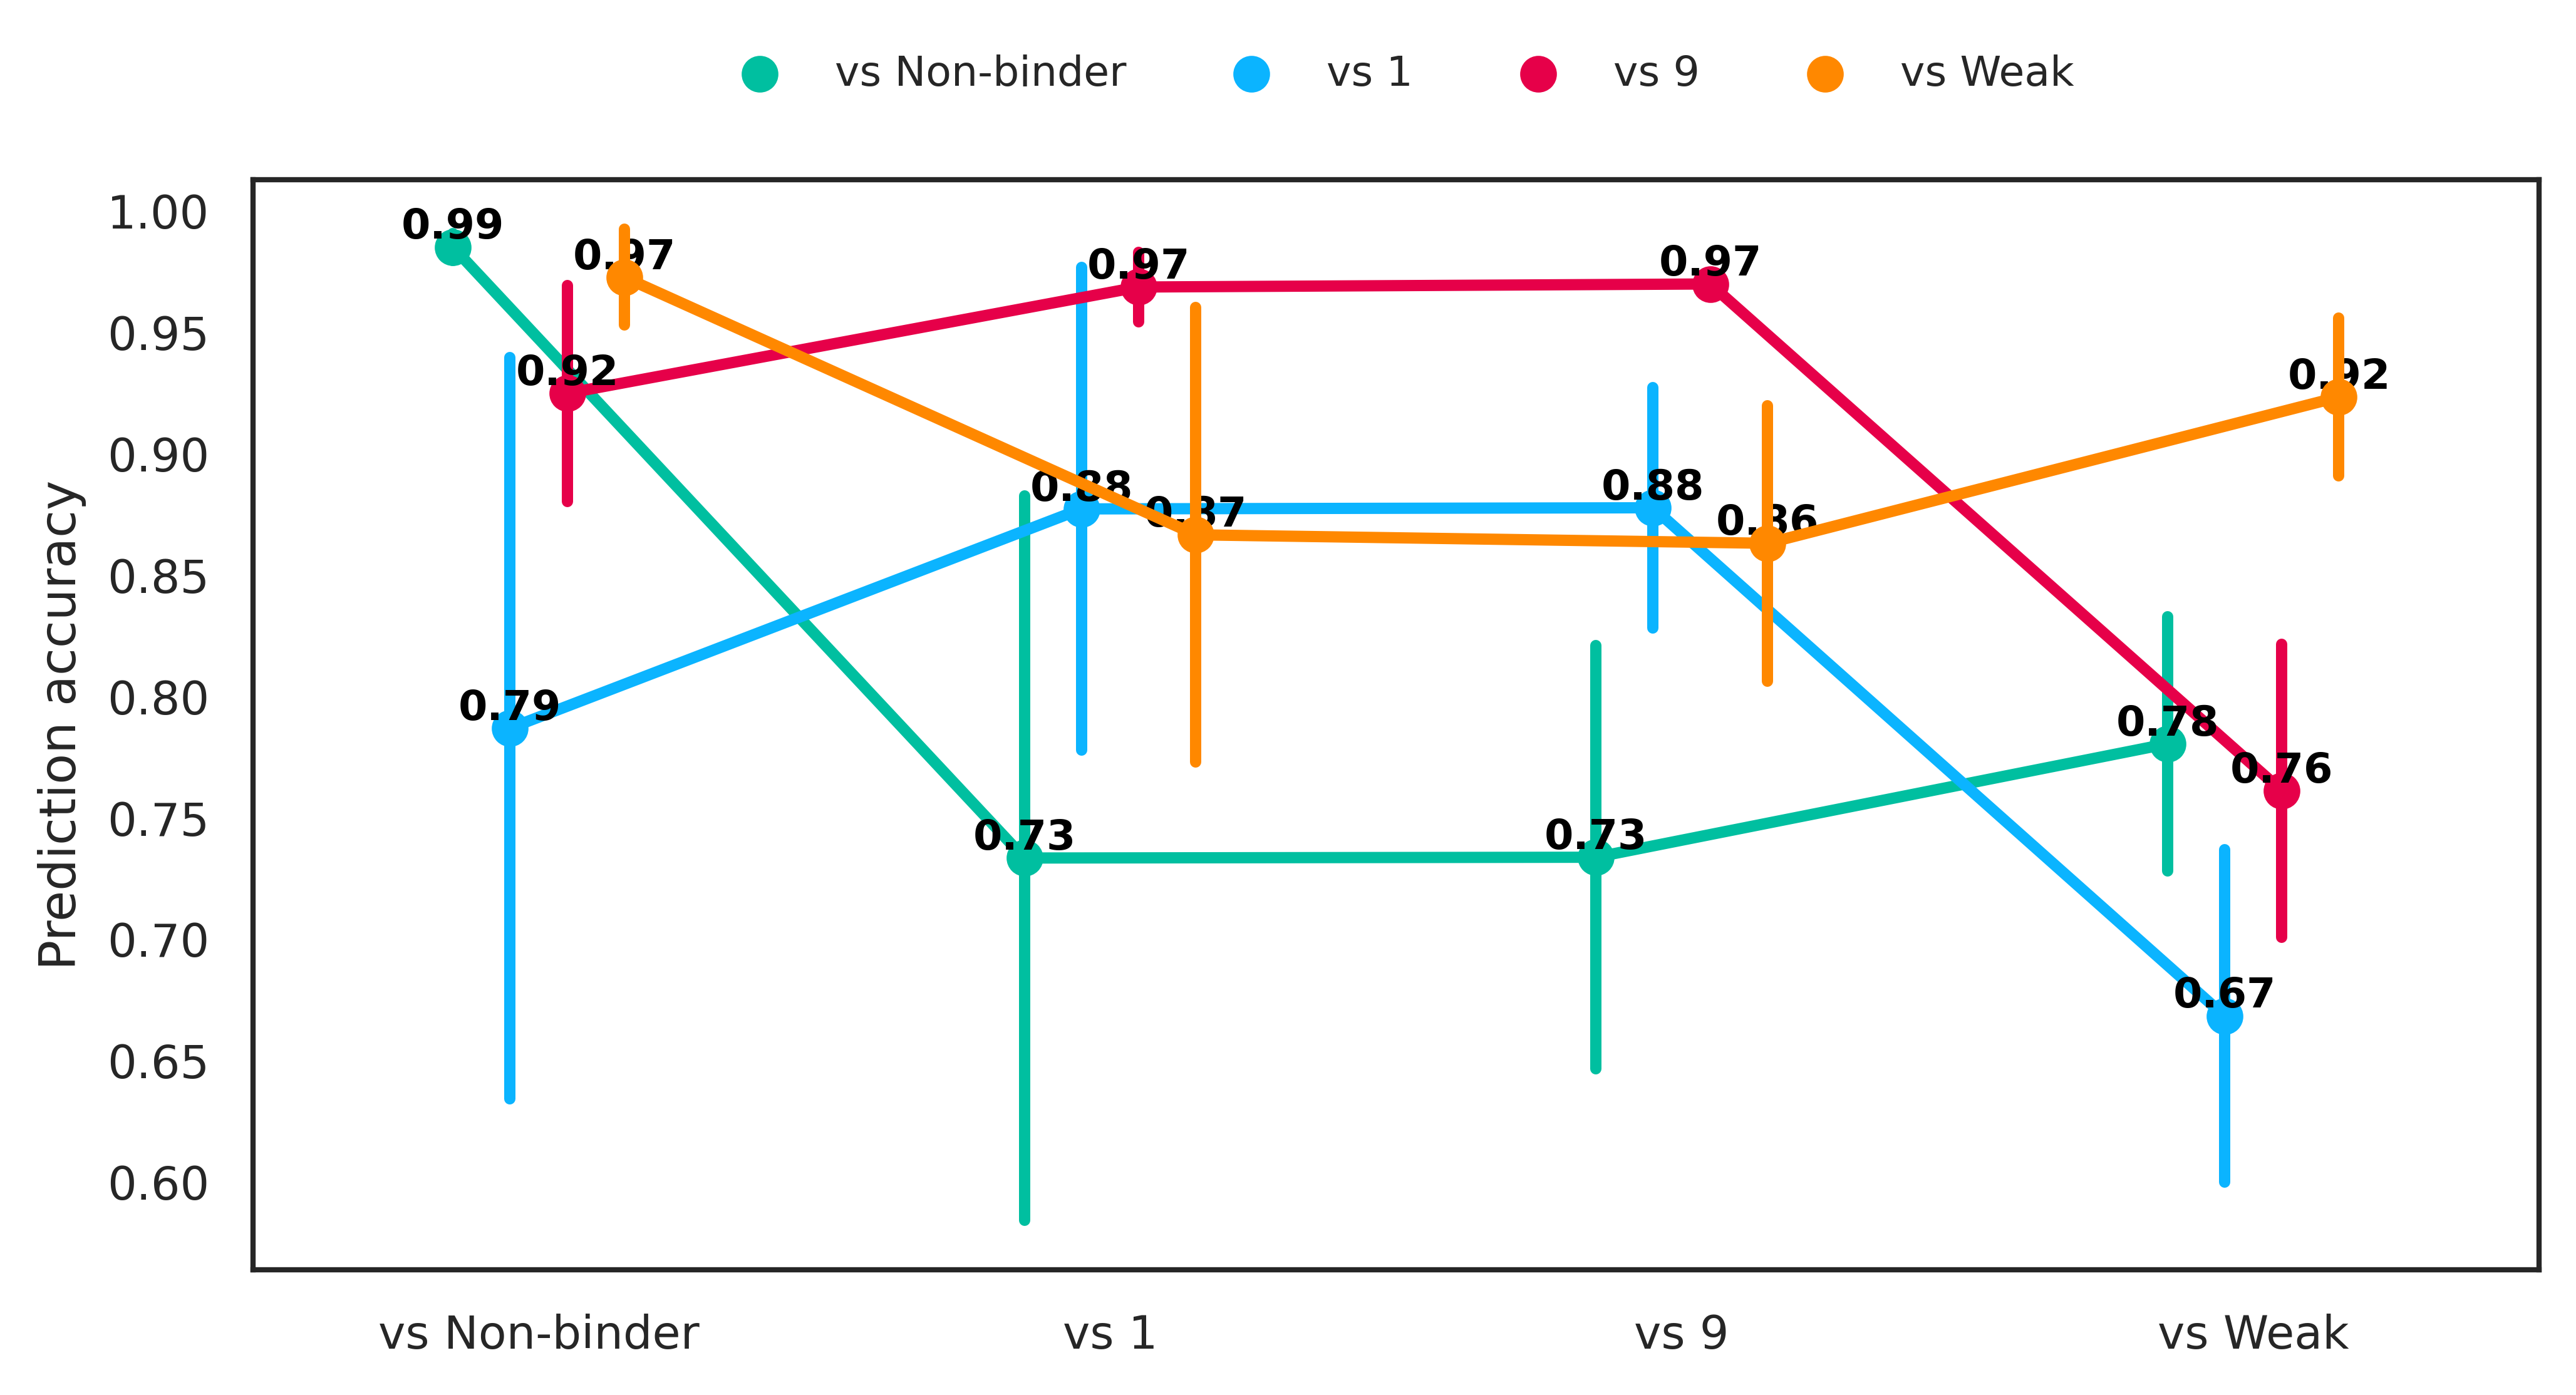

In [17]:
plot_ood(df_ood)

Rule discovery

In [18]:
def task_generator_for_epitopes(all_task_types = False):
    if not all_task_types:
        task_types = [
            datasets.ClassificationTaskType.HIGH_VS_95LOW,
            datasets.ClassificationTaskType.HIGH_VS_LOOSER,
        ]
        for task_type in task_types:
            for ag in config.ANTIGEN_EPITOPES:

                task = datasets.ClassificationTask(
                    task_type=task_type,
                    ag_pos=ag,
                    ag_neg="auto",
                    seed_id=0,
                    split_id=42,
                )
                yield task
    else:
        
        task_types = [
            datasets.ClassificationTaskType.ONE_VS_ONE,
            datasets.ClassificationTaskType.ONE_VS_NINE,
            datasets.ClassificationTaskType.HIGH_VS_95LOW,
            datasets.ClassificationTaskType.HIGH_VS_LOOSER,
        ]
        # For 1v1
        for ag_1 in config.ANTIGEN_EPITOPES:
            for ag_2 in config.ANTIGEN_EPITOPES:
                if ag_1 == ag_2:
                    continue
                task = datasets.ClassificationTask(
                    task_type=datasets.ClassificationTaskType.ONE_VS_ONE,
                    ag_pos=ag_1,
                    ag_neg=ag_2,
                    seed_id=0,
                    split_id=42,
                )
                yield task

        for task_type in task_types[1:]:
            for ag in config.ANTIGEN_EPITOPES:
                task = datasets.ClassificationTask(
                    task_type=task_type,
                    ag_pos=ag,
                    ag_neg="auto",
                    seed_id=0,
                    split_id=42,
                )
                yield task
        


loader = datasets.FrozenMiniAbsolutMLLoader(data_dir=Path("../data/Frozen_MiniAbsolut_ML"))

RD: Logits

In [20]:
from utils_07 import get_miniabsolut_for_epitopes
from scipy.stats import pearsonr


def collect_and_compute_logits_energy_corr(task_generator, fp, force=False, attributions_analysis="v2.0-3-epi"):

    if fp.exists() and not force:
        df_r = pd.read_csv(fp, sep='\t')
    else:
        records = []
        for task in task_generator:

            ## Get attributions and energies
            task = loader.load(task, attributions_toload=attributions_analysis, load_model=True, load_test_dataset=True)    
            
            df = get_miniabsolut_for_epitopes(task)

            ## Compute
            try:
                r, p = pearsonr(df["logits"].dropna(), df["Energy"].dropna())
            except:
                r, p = np.nan, np.nan
            r_pos, p_pos = pearsonr(df[df["y_true"] == 1]["logits"], df[df["y_true"] == 1]["Energy"])
            records.append({
                "task_type": task.task_type.to_str(),
                "ag_pos": task.ag_pos,
                "ag_neg": task.ag_neg,
                "seed_id": task.seed_id,
                "split_id": task.split_id,
                "r": r,
                "p": p,
                "r2": r**2,
                "r_pos": r_pos,
                "r_pos2": r_pos**2,
                "p_pos": p_pos,
                })

        df_r = pd.DataFrame.from_records(records)
        df_r.to_csv(fp, sep='\t', index=False)
    
    return df_r


def plot_logit_energy_corr(df_l):
    fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)
    # sns.set_theme(context="paper")
    # sns.set_style("white")

    task_order = ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]
    sns.stripplot(
        data=df_l, 
        x="task_type", 
        y="r_pos", 
        hue="ag_pos", 
        ax=ax, 
        cmap=visualisations.PlotParams.cmap_antigens,
        order=task_order,
    )

    # Display no legend
    ax.legend_.remove()

    # Relabel xticks
    ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))

    # Add median r_pos per task
    r_median_df = df_l.groupby(["task_type"]).agg({"r_pos": "median"})
    for i, row in r_median_df.iterrows():
        ax.text(
            i,
            -0.95,
            f"{row['r_pos']:.2f}",
            # Center center
            horizontalalignment='center',
        )


    ax.set_ylabel("Pearson correlation coefficient")
    ax.set_xlabel("Task")

RD: Attributions

In [21]:
from utils_07 import load_energy_contributions_from_task_nonlinear_version


def collect_and_compute_attrs_energy_corr(
    task_generator, 
    fp, 
    analysis_name, 
    force=False,
):
    
    if Path(fp).exists() and not force:
        df_attrib = pd.read_csv(fp, sep="\t")
    else:

        records = []
        for task in task_generator:        
            task = loader.load(task, attributions_toload=analysis_name, load_model=False, load_test_dataset=False)
            stats = load_energy_contributions_from_task_nonlinear_version(
                task, 
                load_slide_df=False, 
                load_everything=False,
                attributor_name=f"DeepLIFT_LOCAL_{analysis_name}",
                attribution_records_toload="attribution_records.json",
                task_is_loaded=True,
                load_miniabsolut_for_shuffled=False,
                attr_analysis_name=analysis_name,
                load_miniabsolut_type="epitope_analysis",
                )
            records.append(stats)

        df_attrib = pd.DataFrame.from_records(records)
        df_attrib.to_csv(fp, index=False, sep='\t')
    
    return df_attrib


def plot_attr_energy_corr(df_attrib):

    fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)
    sns.set_theme(context="paper")
    sns.set_style("white")

    task_order = ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]
    sns.stripplot(
        data=df_attrib, 
        x="task_type", 
        y="mean_pos_total", 
        order=task_order,
        hue="ag_pos",
        ax=ax,
        cmap=visualisations.PlotParams.cmap_antigens,
    )

    ax.legend_.remove()

    # Relabel xticks
    ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))

    # Add median r_pos per task
    r_median_df = df_attrib.groupby(["task_type"]).agg({"mean_pos_total": "median"})
    for i, row in r_median_df.iterrows():
        ax.text(
            i,
            -0.87,
            f"{row['mean_pos_total']:.2f}",
            # Center center
            horizontalalignment='center',
        )

    # ax.set_title("Mean{Correlation(Energycontribution, Attribution)} for positive class")
    ax.set_ylabel("Pearson correlation coefficient")
    ax.set_xlabel("Task")

Do logits and attributions for epipos

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/seaborn/categorical.py:299: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(sub_data["x"], sub_data["y"], color=color, **plot_kws)
/tmp/ipykernel_72449/3112617140.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))


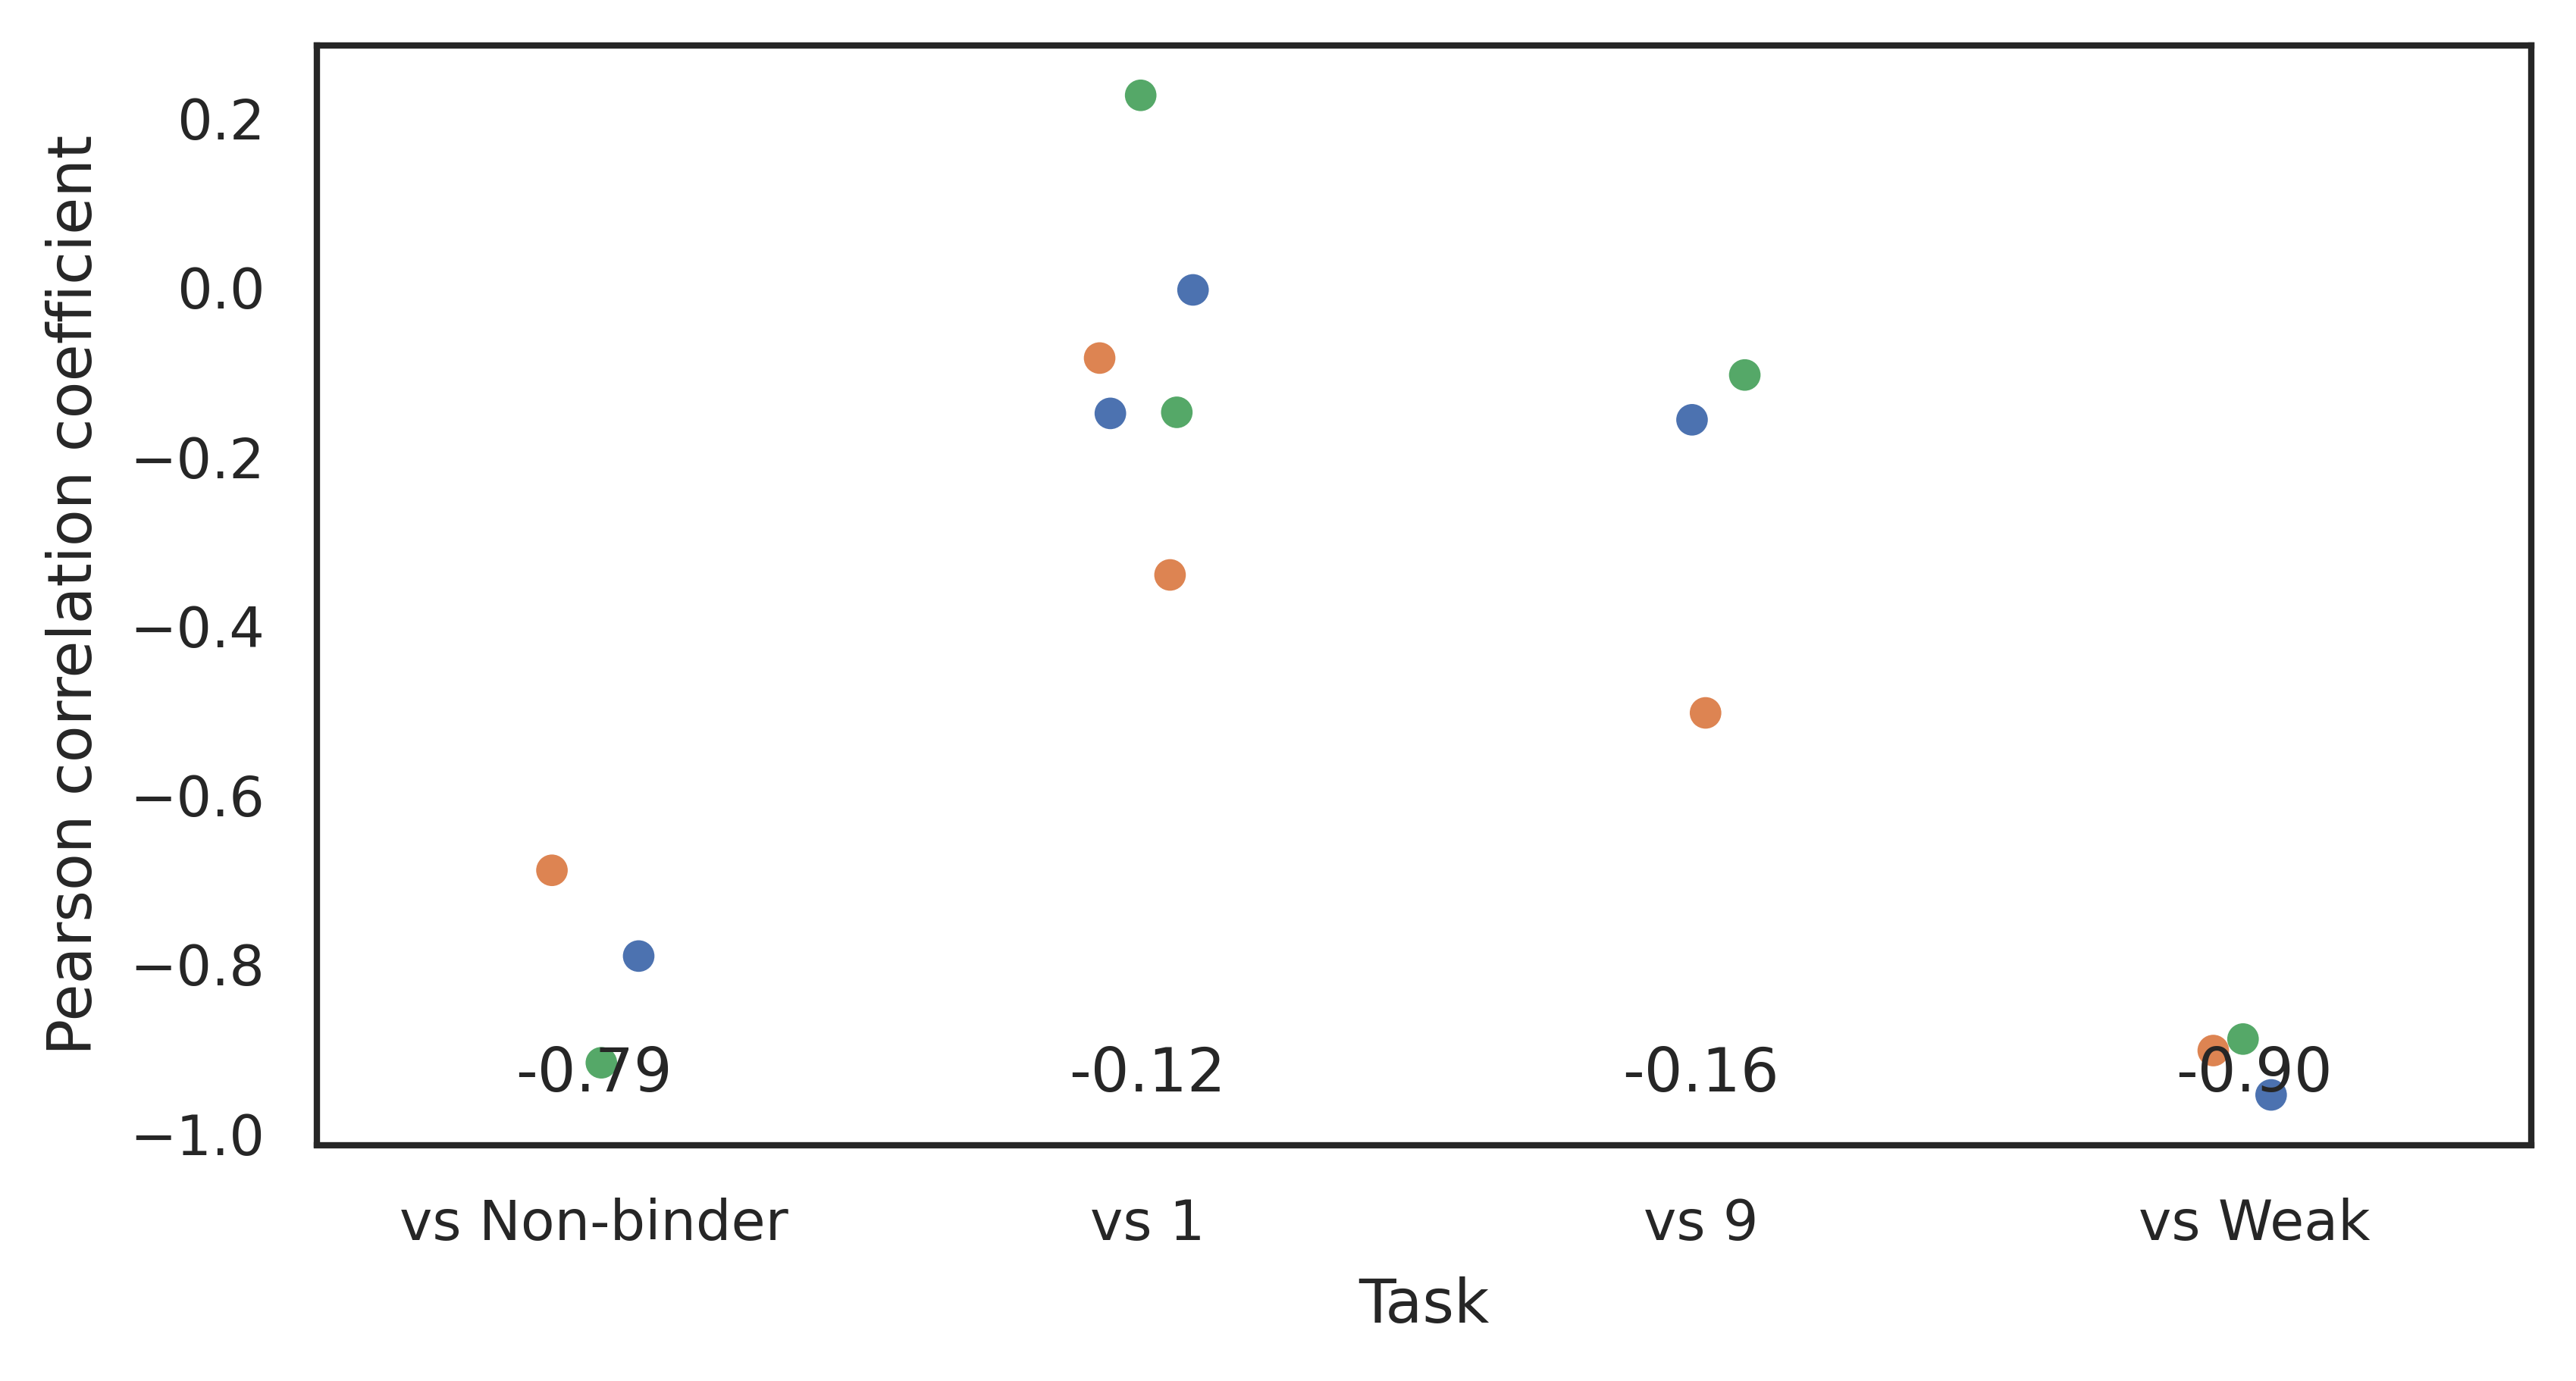

In [22]:
fp = Path("25d_Logit_Energies_EpiPos.tsv")
attributions_analysis = "v2.0-3-epipos"
force = False


df_logits = collect_and_compute_logits_energy_corr(
    task_generator_for_epitopes(all_task_types=True), 
    fp, 
    force, 
    attributions_analysis
)

df_logits.groupby(["task_type"]).agg({"r_pos": ["min", "median", "max"]})

plot_logit_energy_corr(df_logits)

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/seaborn/categorical.py:299: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(sub_data["x"], sub_data["y"], color=color, **plot_kws)
/tmp/ipykernel_72449/2872020853.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))


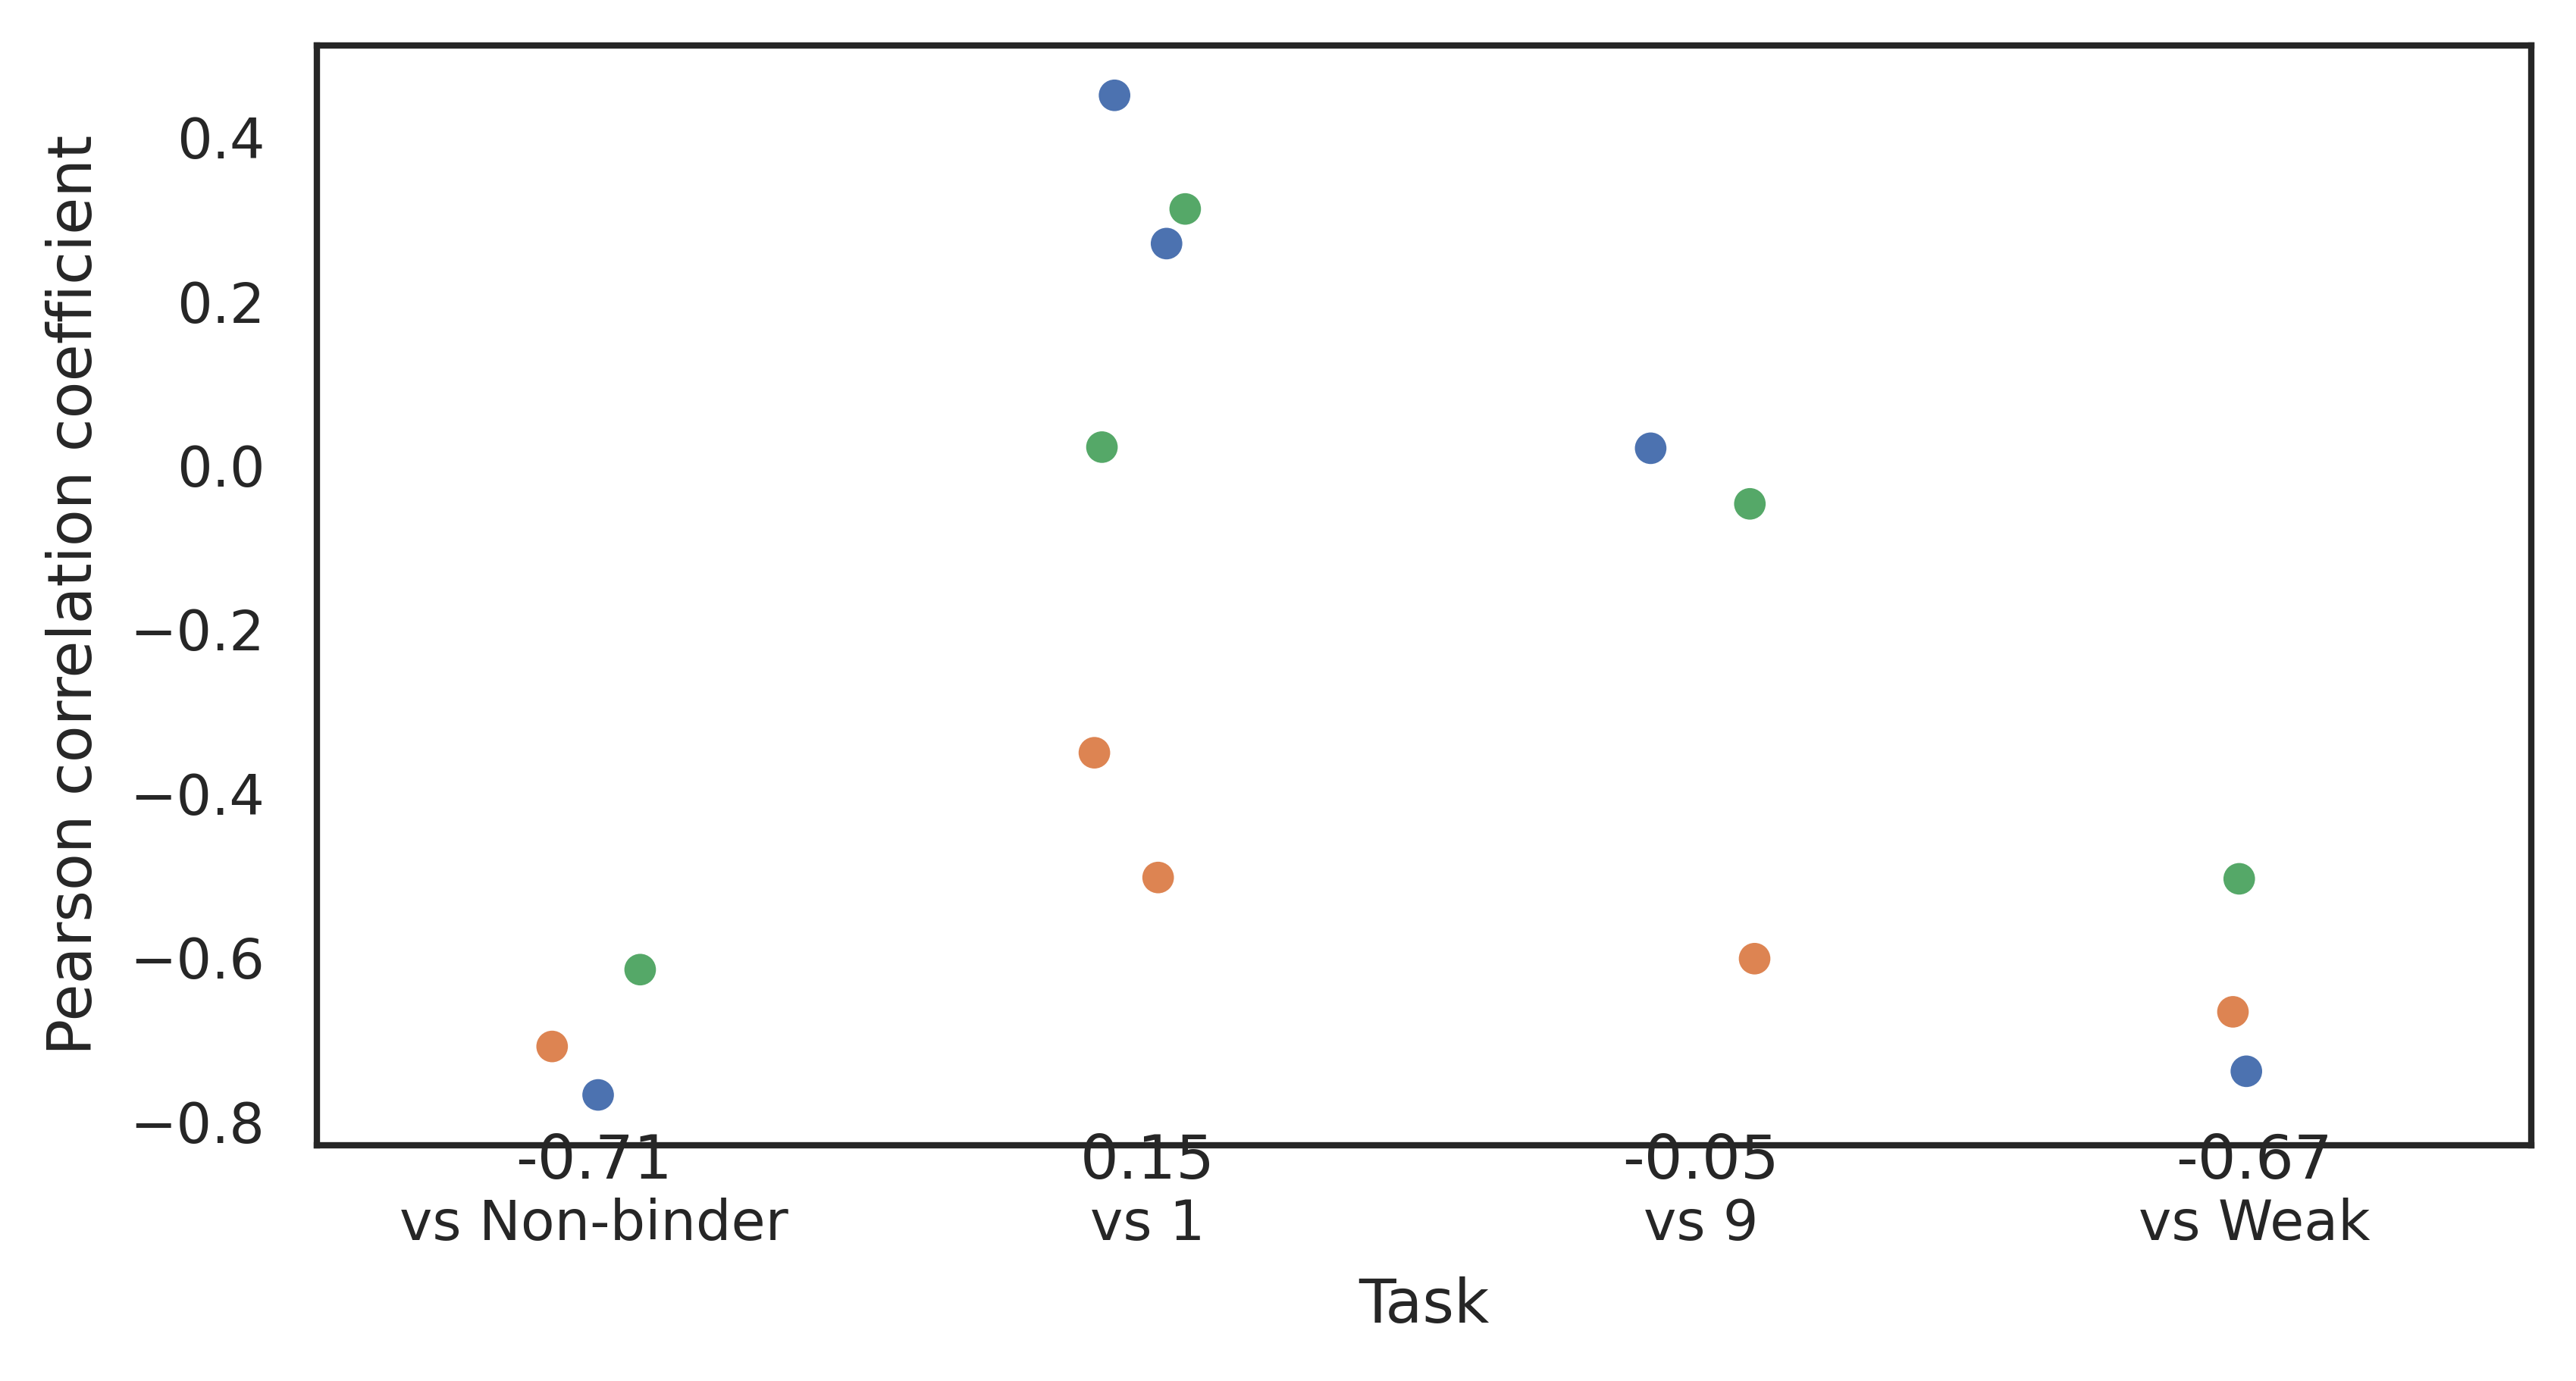

In [23]:
fp = "25d_Attribution_Energies_EpiPos.tsv"
analysis_name = "v2.0-3-epipos"
force = False

df_attr = collect_and_compute_attrs_energy_corr(
    task_generator_for_epitopes(all_task_types=True),
    fp,
    analysis_name,
    force=force,
)

plot_attr_energy_corr(df_attr)

Aggregate with results from non-epitope specific analysis.

Logits

In [24]:
df_logits_antigen = pd.read_csv(
    "../data/Frozen_MiniAbsolut_ML/07e_LogitEnergyCorrelations_final.tsv",
)  # r_pos



In [25]:
df_logits_ext = pd.concat([df_logits, df_logits_antigen], axis=0)
df_logits_ext["task_type_clean"] = df_logits_ext["task_type"].apply(lambda x: visualisations.PlotParams.map_task_type_to_clean[x])

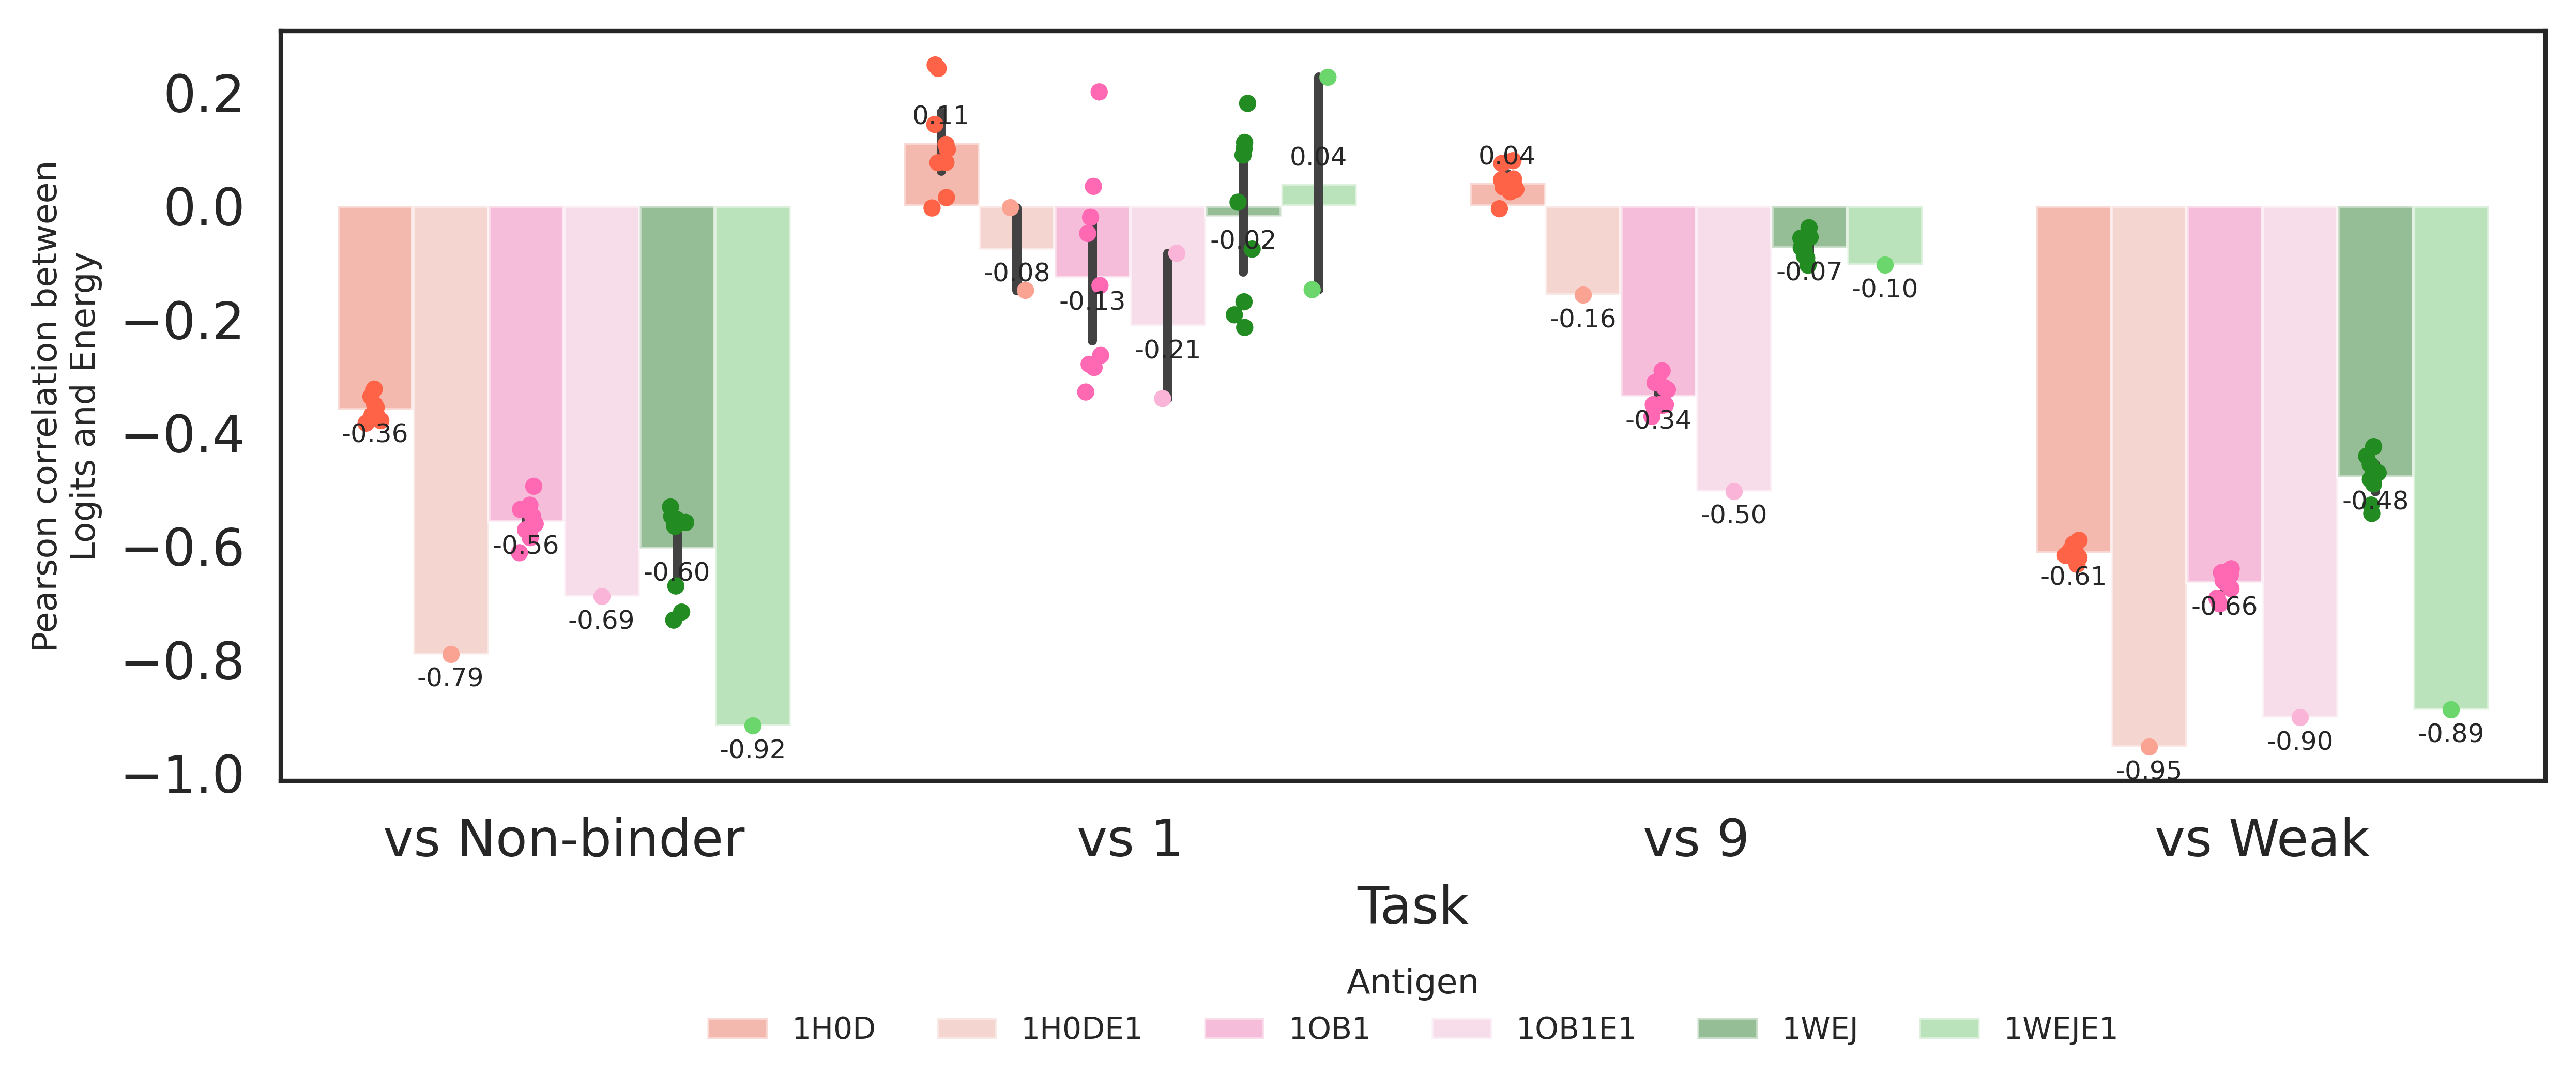

In [26]:
ag_order = ["1H0D", "1H0DE1", "1OB1", "1OB1E1", "1WEJ", "1WEJE1"]
task_order = ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]
task_clean_order = [visualisations.PlotParams.map_task_type_to_clean[x] for x in task_order]

palette = {
 '1WEJ': '#228B22',
 '1WEJE1': "#6bd66b",
 '1OB1': '#FF69B4',
 '1OB1E1': '#fab4d7',
 '1H0D': '#FF6347',
 '1H0DE1': '#faa393',
}

sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(3 * 3.14, 3.14), dpi=600)

# Transparent boxplot
sns.barplot(
    x="task_type_clean",
    y="r_pos",
    hue="ag_pos",
    data=df_logits_ext,
    ax=ax,
    order=task_clean_order,
    hue_order=ag_order,
    palette=palette,
    alpha=0.5,
)
# Add data points on top of boxplot in low transparency
sns.stripplot(
    x="task_type_clean",
    y="r_pos",
    hue="ag_pos",
    data=df_logits_ext,
    ax=ax,
    order=task_clean_order,
    hue_order=ag_order,
    palette=palette,
    alpha=1.0,
    dodge=True,
    size=4,
    legend=False, # type: ignore
)

# visualisations.add_median_labels(ax, y_level=0.85, fontsize=8)
for i in range(6):
    ax.bar_label(ax.containers[i], fontsize=6, fmt="%1.2f", label_type="edge", padding=3)

ax.tick_params(labelsize=12)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Antigen",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)
ax.set_xlabel("Task", fontsize=12)
ax.set_ylabel("Pearson correlation between\nLogits and Energy", fontsize=8)
# ax.set_title("", fontsize=12)

# fig.savefig("")
fig.show()

Attributions

In [27]:
df_attrib_antigen = pd.read_csv(
    "../data/Frozen_MiniAbsolut_ML/07e_EnergyContributions.tsv",
    sep='\t'
)  # mean_pos_total

df_attrib_antigen.query("ag_pos in @antigens_selector", inplace=True)
df_attrib_antigen.head()

,task_type,ag_pos,ag_neg,seed_id,split_id,mean,std,mean_pos,std_pos,mean_neg,...,mean_pos_fold,std_pos_fold,mean_neg_fold,std_neg_fold,mean_total,std_total,mean_pos_total,std_pos_total,mean_neg_total,std_neg_total
36,1v1,1H0D,3VRL,0,42,0.678519,0.139358,0.678519,0.139358,NaN,...,0.196415,0.259347,NaN,NaN,0.693188,0.129489,0.693188,0.129489,NaN,NaN
37,1v1,1H0D,1NSN,0,42,0.008643,0.281042,0.008643,0.281042,NaN,...,0.097452,0.195854,NaN,NaN,0.039685,0.258803,0.039685,0.258803,NaN,NaN
38,1v1,1H0D,3RAJ,0,42,0.784868,0.117346,0.784868,0.117346,NaN,...,0.156607,0.256041,NaN,NaN,0.785472,0.118686,0.785472,0.118686,NaN,NaN
39,1v1,1H0D,5E94,0,42,0.708800,0.119821,0.708800,0.119821,NaN,...,0.159911,0.302915,NaN,NaN,0.715190,0.115447,0.715190,0.115447,NaN,NaN
40,1v1,1H0D,1WEJ,0,42,0.613128,0.183912,0.613128,0.183912,NaN,...,0.107655,0.304084,NaN,NaN,0.613941,0.182134,0.613941,0.182134,NaN,NaN


In [28]:
df_attrib_ext = pd.concat([df_attr, df_attrib_antigen], axis=0)
df_attrib_ext["task_type_clean"] = df_attrib_ext["task_type"].apply(lambda x: visualisations.PlotParams.map_task_type_to_clean[x])

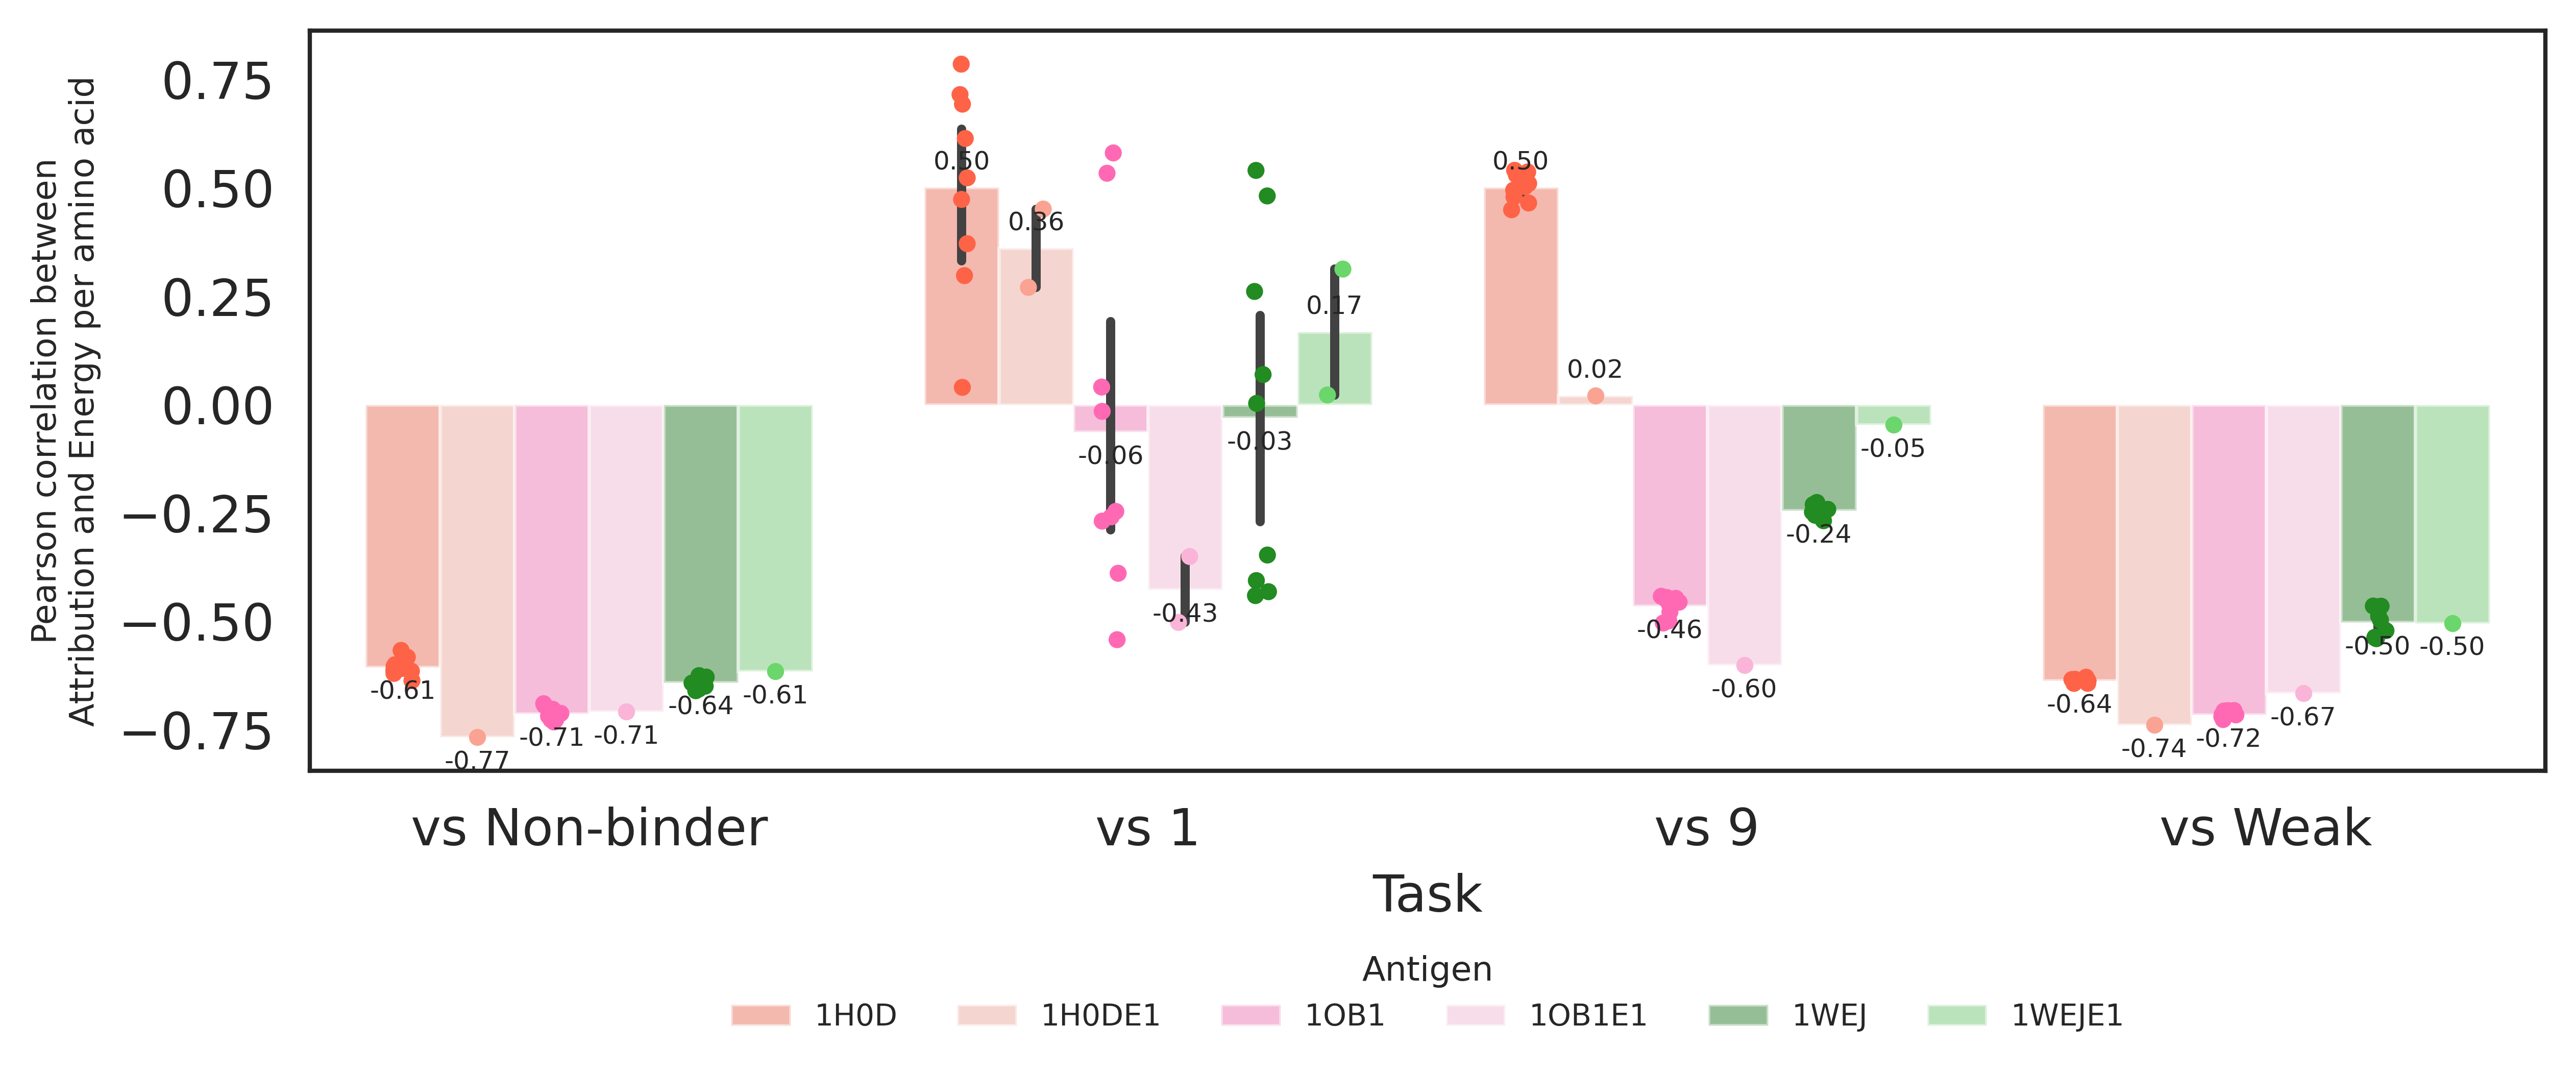

In [29]:
ag_order = ["1H0D", "1H0DE1", "1OB1", "1OB1E1", "1WEJ", "1WEJE1"]
task_order = ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]
task_clean_order = [visualisations.PlotParams.map_task_type_to_clean[x] for x in task_order]

palette = {
 '1WEJ': '#228B22',
 '1WEJE1': "#6bd66b",
 '1OB1': '#FF69B4',
 '1OB1E1': '#fab4d7',
 '1H0D': '#FF6347',
 '1H0DE1': '#faa393',
}

sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(3 * 3.14, 3.14), dpi=600)

# Transparent boxplot
sns.barplot(
    x="task_type_clean",
    y="mean_pos_total",
    hue="ag_pos",
    data=df_attrib_ext,
    ax=ax,
    order=task_clean_order,
    hue_order=ag_order,
    palette=palette,
    alpha=0.5,
)
# Add data points on top of boxplot in low transparency
sns.stripplot(
    x="task_type_clean",
    y="mean_pos_total",
    hue="ag_pos",
    data=df_attrib_ext,
    ax=ax,
    order=task_clean_order,
    hue_order=ag_order,
    palette=palette,
    alpha=1.0,
    dodge=True,
    size=4,
    legend=False, # type: ignore
)

# visualisations.add_median_labels(ax, y_level=0.85, fontsize=8)
for i in range(6):
    ax.bar_label(ax.containers[i], fontsize=6, fmt="%1.2f", label_type="edge", padding=3)

ax.tick_params(labelsize=12)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Antigen",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)
ax.set_xlabel("Task", fontsize=12)
ax.set_ylabel("Pearson correlation between\nAttribution and Energy per amino acid", fontsize=8)
# ax.set_title("", fontsize=12)

# fig.savefig("")
fig.show()